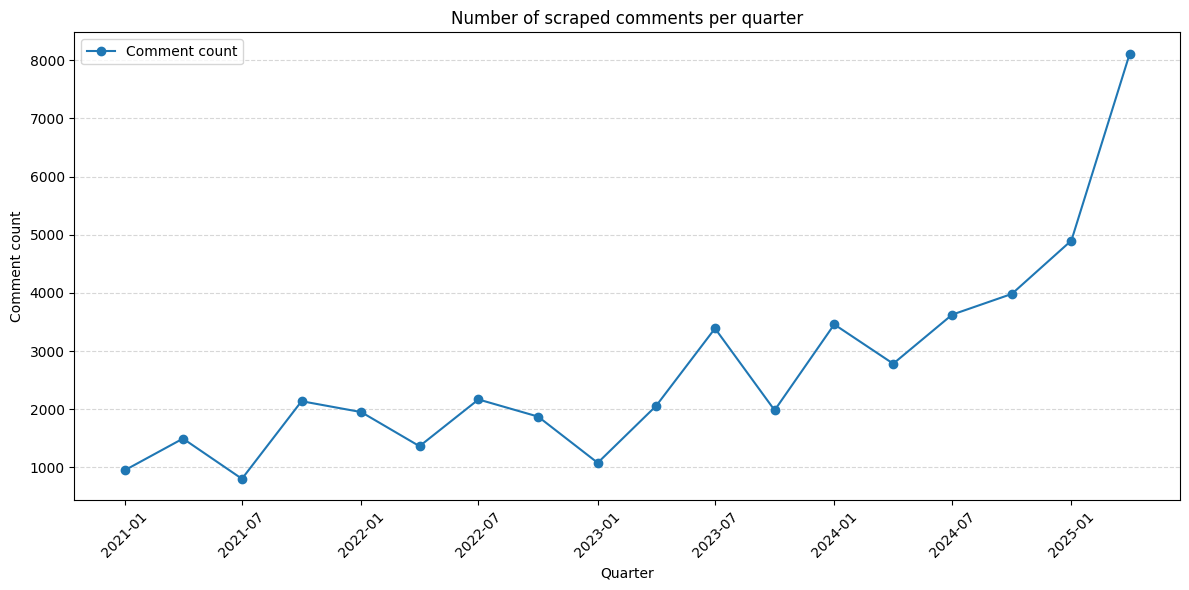

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
df = pd.read_csv("Database/comments_spillover.csv")

# === 2. Parse datetime ===
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df = df.dropna(subset=["published_at"])
df["published_at"] = df["published_at"].dt.tz_localize(None)

# === 3. Group by quarter (non week!) ===
df["quarter"] = df["published_at"].dt.to_period("Q").apply(lambda r: r.start_time)
quarterly_counts = df.groupby("quarter").size().reset_index(name="comment_count")

# === 4. Plot results ===
plt.figure(figsize=(12, 6))
plt.plot(
    quarterly_counts["quarter"],
    quarterly_counts["comment_count"],
    marker="o",
    linestyle="-",
    label="Comment count"
)

plt.title("Number of scraped comments per quarter")
plt.xlabel("Quarter")
plt.ylabel("Comment count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\01and\AppData\Local\Temp\ipykernel_27520\2146467029.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_score)


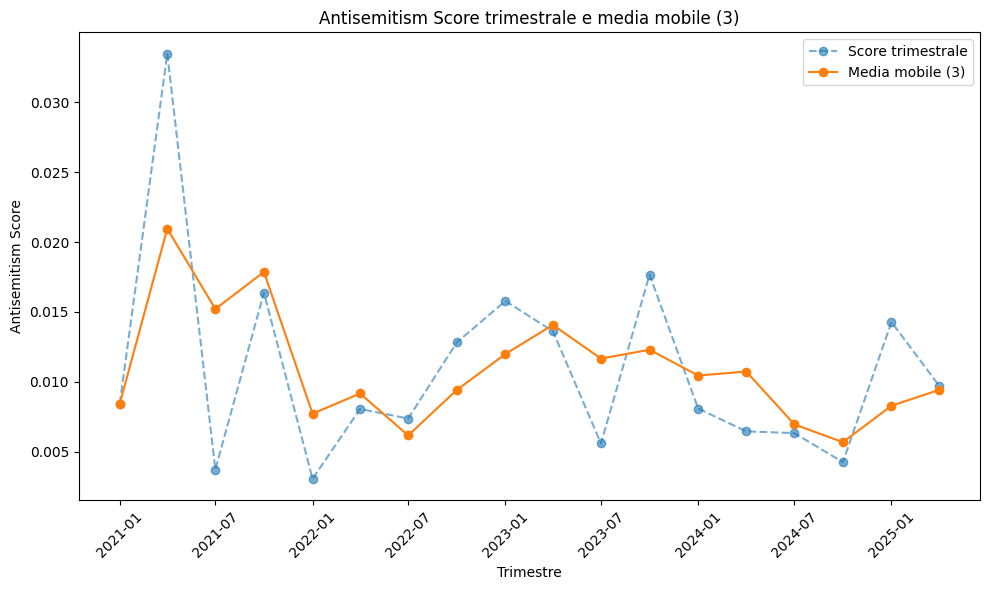

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Parametro: 1 = media pesata con upvotes, 0 = media semplice ---
mediapesata = 0

# Enable inline plotting (se sei in Jupyter)
%matplotlib inline

# Path to the results CSV
results_csv_path = 'Database/classification_results_spillover.csv'

# Load and preprocess
df = pd.read_csv(results_csv_path, parse_dates=['published_at'])
df['published_at'] = df['published_at'].dt.tz_localize(None)
df['upvotes'] = df['upvotes'].astype(float)
df['label'] = df['label'].astype(int)

# Trimestre di riferimento per ciascun commento
df['quarter_start'] = df['published_at'].dt.to_period('Q').dt.start_time

# Funzione per calcolare lo score per trimestre
def calc_score(group):
    if mediapesata == 1:
        tot_up = group['upvotes'].sum()
        return (group['upvotes'] * group['label']).sum() / tot_up if tot_up > 0 else 0.0
    else:
        return group['label'].mean()

# Aggregazione per trimestre
quarterly = (
    df.groupby('quarter_start')
      .apply(calc_score)
      .reset_index(name='antisemitism_score')
      .sort_values('quarter_start')
      .reset_index(drop=True)
)

# Media mobile su 3 trimestri
quarterly['rolling_mean_3'] = quarterly['antisemitism_score'].rolling(window=3, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly['quarter_start'], quarterly['antisemitism_score'], marker='o', linestyle='--', alpha=0.6, label='Score trimestrale')
ax.plot(quarterly['quarter_start'], quarterly['rolling_mean_3'], marker='o', label='Media mobile (3)')

ax.set_xlabel('Trimestre')
ax.set_ylabel('Antisemitism Score')
ax.set_title('Antisemitism Score trimestrale e media mobile (3)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


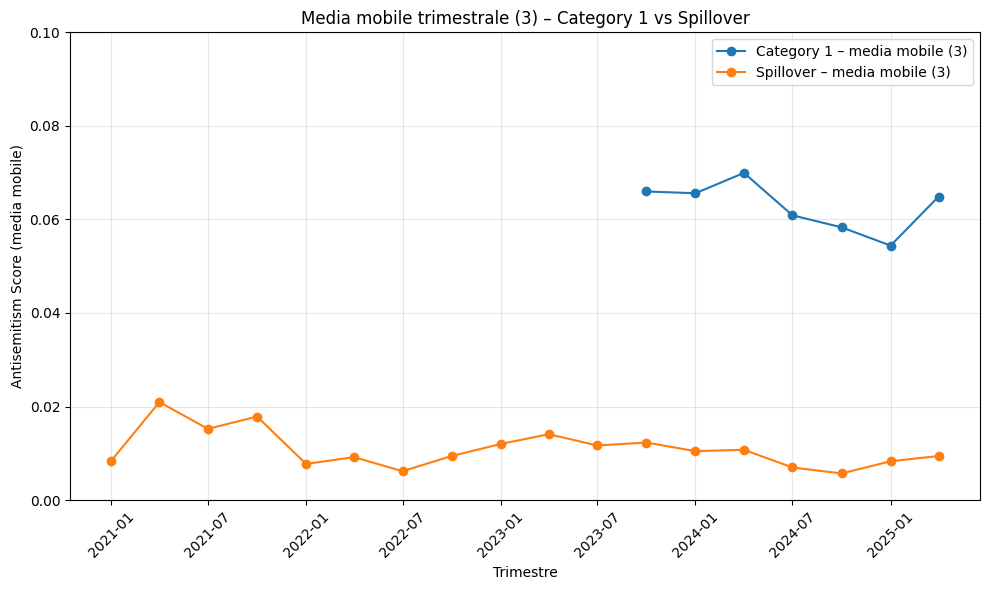

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Parametri ---
mediapesata = 0  # 1 = media pesata con upvotes, 0 = media semplice
window = 3  # lunghezza media mobile in trimestri
fill_missing = 'ffill'  # 'ffill' | 'bfill' | None
save_path = None  # es. 'Database/rolling_q_cat1_vs_spill.png' oppure None

# (facoltativo, se sei in Jupyter)
%matplotlib inline

cat1_path = 'Database/classification_results_category1.csv'
spill_path = 'Database/classification_results_spillover.csv'


def load_quarterly_series(path: str, weighted: int = 0) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=['published_at'])
    df['published_at'] = df['published_at'].dt.tz_localize(None)
    df['upvotes'] = df['upvotes'].astype(float)
    df['label'] = df['label'].astype(int)

    # Trimestre di riferimento
    df['quarter_start'] = df['published_at'].dt.to_period('Q').dt.start_time

    # Calcolo score per trimestre
    def calc_score(g):
        if weighted == 1:
            tot_up = g['upvotes'].sum()
            return (g['upvotes'] * g['label']).sum() / tot_up if tot_up > 0 else 0.0
        else:
            return g['label'].mean()

    quarterly = (
        df.groupby('quarter_start')[['upvotes', 'label']]
        .apply(calc_score)
        .reset_index(name='antisemitism_score')
        .sort_values('quarter_start')
        .set_index('quarter_start')
    )
    return quarterly


# Carica serie trimestrali (score puntuali)
q_cat1 = load_quarterly_series(cat1_path, weighted=mediapesata)
q_spill = load_quarterly_series(spill_path, weighted=mediapesata)

# Costruisci un asse temporale trimestrale comune (union dei trimestri)
start = min(q_cat1.index.min(), q_spill.index.min())
end = max(q_cat1.index.max(), q_spill.index.max())
common_idx = pd.period_range(start=start, end=end, freq='Q').to_timestamp()

# Reindicizza e gestisci i missing prima della rolling
q_cat1 = q_cat1.reindex(common_idx)
q_spill = q_spill.reindex(common_idx)

if fill_missing == 'ffill':
    q_cat1 = q_cat1.ffill()
    q_spill = q_spill.ffill()
elif fill_missing == 'bfill':
    q_cat1 = q_cat1.bfill()
    q_spill = q_spill.bfill()
# se None, lasciamo NaN

# Media mobile su finestra 'window'
q_cat1['rolling_mean'] = q_cat1['antisemitism_score'].rolling(window=window, min_periods=1).mean()
q_spill['rolling_mean'] = q_spill['antisemitism_score'].rolling(window=window, min_periods=1).mean()

# Plot: SOLO media mobile
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(common_idx, q_cat1['rolling_mean'], marker='o', label=f'Category 1 – media mobile ({window})')
ax.plot(common_idx, q_spill['rolling_mean'], marker='o', label=f'Spillover – media mobile ({window})')

ax.set_xlabel('Trimestre')
ax.set_ylabel('Antisemitism Score (media mobile)')
ax.set_title(f'Media mobile trimestrale ({window}) – Category 1 vs Spillover')
ax.set_ylim(0, 0.1)  # limite aggiornato a 0.1
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

if save_path:
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

plt.show()
